# Trialing Landslide Activity Filters

## Setup

In [1]:
# run in forrestwilliams/gis:1.03
%matplotlib inline
import rasterio as rio
import geopandas as gpd
import richdem as rd
from pathlib import Path
from rasterstats import zonal_stats
from skimage import morphology
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
cd /home/micromamba/data

/home/micromamba/data


In [3]:
def read_raster(path,bands=1,crs=False):
    with rio.open(path) as dst:
        array = dst.read(bands)
        profile = dst.profile
        crs_val = dst.crs
        # array = np.moveaxis(array,0,-1)
    
    result = [array, profile]

    if crs:
        result.append(crs_val)

    return result


def write_raster(array,profile,out_path,dtype=rio.uint8):
    # From rasterio docs:
    # Register GDAL format drivers and configuration options with a
    # context manager.
    with rio.Env():
        # And then change the band count to 1, set the
        # dtype to uint8, and specify LZW compression.
        profile.update(
            dtype=dtype,
            count=1,
            compress='lzw')

        with rio.open(out_path, 'w', **profile) as dst:
            dst.write(array.astype(dtype), 1)

    return out_path


def vel_coh_filter(vel_array, coh_array, coh_thresh, n_std=2, min_size=None):
    data = vel_array.copy()

    # mask pixels with velocities less than 2 x velocity std in space
    mean = np.nanmean(vel_array)
    std = np.nanstd(vel_array)
    vel_mask = np.abs(vel_array - mean) > (std * n_std)
    
    # mask pixels with temporal coherence below threshold
    coh_mask = coh_array > coh_thresh
    mask = vel_mask & coh_mask

    # optionally remove small objects (min size in pixels)
    if min_size:
        mask = morphology.remove_small_objects(mask,min_size=min_size)
    
    data[~mask] = np.nan
    
    return (data, mask)


def bekaert_filter(vel_array, std_array, n_std=2, min_size=None):
    data = vel_array.copy()
    
    # mask pixels less than 2 x temporal standard deviation
    mask = np.abs(data - np.nanmean(vel_array)) > (n_std * std_array)

    # optionally remove small objects (min size in pixels)
    if min_size:
        mask = morphology.remove_small_objects(mask,min_size=min_size)
    
    data[~mask] = np.nan
    
    return (data, mask)


def gdf_zonal_stats(gdf,data,affine,statistic):
    # Get polygons
    zones = list(gdf.geometry)

    # Perform zonal stats and convert to pandas series
    zs = zonal_stats(zones, data.astype(float), affine=affine,stats=[statistic],nodata=0.0)
    result = pd.Series([x[statistic] for x in zs])
    
    return result


def add_trial_column(gdf,data,affine,col_name):
    # Perform zonal stats
    counts = gdf_zonal_stats(gdf,data,affine,'count')

    # Change count to binary measure of activity and add to geodataframe
    gdf[col_name] = (counts > 0).astype(int)

    return gdf

## Prep landslide activity test dataset

In [12]:
active_type = 'active'

ls_path = Path('activity_validation_set.shp')
test_set = gpd.read_file(ls_path).to_crs(32760).reset_index(drop=True)

test_set = test_set[['Name','area_ha',active_type,'geometry']]
test_set = test_set.rename(columns={'Name':'name',active_type:'active'})
test_set['area_ha'] = test_set.geometry.area / 1e4

### Calculate Average Aspect

In [13]:
# dem, profile = read_raster()
# aspect = rd.aspect(dem)

imagery_path = Path('imagery')
in_dem = imagery_path / 'northIslandOtago.tif'
dem_path = imagery_path / 'dem.tif'
minx, miny, maxx, maxy = test_set.copy().buffer(10000).total_bounds
epsg = f'EPSG:{test_set.crs.to_epsg()}'

In [6]:
# !gdal_translate -projwin {minx} {maxy} {maxx} {miny} -projwin_srs {epsg} {str(in_dem)} subset.tif
# !gdalwarp -t_srs {epsg} subset.tif {str(dem_path)}
# !rm subset.tif

Input file size is 40000, 61433
Warning 1: for band 1, nodata value has been clamped to -32768, the original value being out of range.
0...10...20...30...40...50...60...70...80...90...100 - done.
Processing subset.tif [1/1] : 0Using internal nodata values (e.g. -32768) for image subset.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [14]:
dem, dem_profile = read_raster(dem_path)
dem_affine = dem_profile['transform']

In [15]:
%%capture
rdem = rd.rdarray(dem, no_data=-32768)
aspect = rd.TerrainAttribute(rdem, attrib='aspect')

aspect = np.array(aspect)
aspect[aspect < 0] = np.nan
aspect = np.deg2rad(aspect)
# write_raster(aspect,dem_profile,'aspect.tif',dtype=rio.float32)


A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 2.35927                         ] (30% - 5.5s - 1 threads))


In [16]:
# Calculate circular mean from:
# https://en.wikipedia.org/wiki/Circular_mean

sin_aspect = gdf_zonal_stats(test_set,np.sin(aspect),dem_affine,'sum')
cos_aspect = gdf_zonal_stats(test_set,np.cos(aspect),dem_affine,'sum')

avg_aspect = np.rad2deg(np.arctan2(sin_aspect,cos_aspect))
test_set['aspect'] = avg_aspect

## Trial activity filters

### Load Data

In [17]:
dataset_names = ['velocity_desc','temporalCoherence_desc','std_desc',
                 'velocity_asc','std_asc','temporalCoherence_asc']

In [18]:
datasets = {}
for d in dataset_names:
    years_dic = {}
    name = f'{d}_2019.tif'
    print(f'Reading {name} ...')
    years_dic['2019'] = read_raster(name)[0]

    datasets[d] = years_dic

print('Done!')

Reading velocity_desc_2019.tif ...
Reading temporalCoherence_desc_2019.tif ...
Reading std_desc_2019.tif ...
Reading velocity_asc_2019.tif ...
Reading std_asc_2019.tif ...
Reading temporalCoherence_asc_2019.tif ...
Done!


In [19]:
profile = read_raster('velocity_desc_2019.tif')[1]
affine = profile['transform']

## Data exploration

In [31]:
test_set.shape

(60, 5)

In [32]:
test_set[['active','area_ha']].groupby('active').describe()

area_ha                                                       \
         count        mean         std      min       25%       50%   
active                                                                
0         48.0   36.992960   39.712365  10.0208  11.83910  23.48115   
1         12.0  224.956917  313.820471  24.8580  67.75985  91.72905   

                             
              75%       max  
active                       
0        43.80525   229.707  
1       179.30625  1047.390

In [33]:
coh = datasets['temporalCoherence_desc']['2019']
vel = datasets['velocity_desc']['2019']

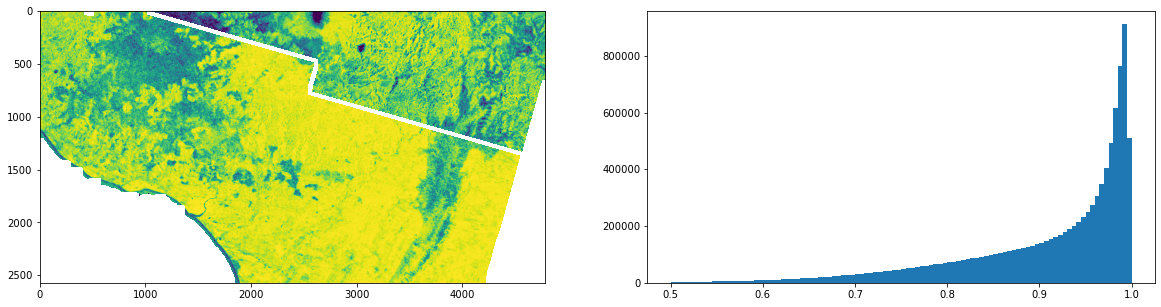

In [34]:
vmin, vmax = (0.5,1)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.imshow(coh,vmin=vmin,vmax=vmax)
h=ax2.hist(coh.flatten(),range=(vmin,vmax),bins=100)

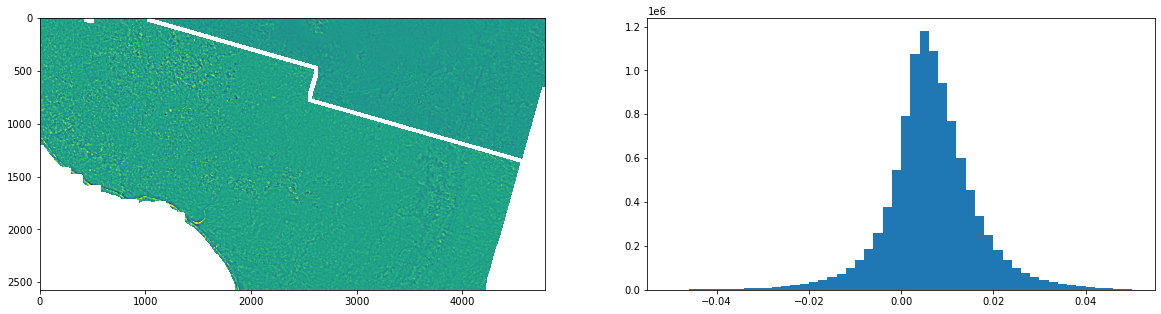

In [35]:
vmin, vmax = (-0.05,0.05)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
ax1.imshow(vel,vmin=vmin,vmax=vmax)
h=ax2.hist(vel.flatten(),range=(vmin,vmax),bins=50)

## Filter Trials

In [20]:
min_size = 10
coh_thresh = 0.9
n_std = 2

### Bekaert Desc

In [21]:
# best value is n_std = 11
name = f'std_desc_2019'
data, mask = bekaert_filter(datasets['velocity_desc']['2019'], datasets['std_desc']['2019'], min_size=min_size)
test_set = add_trial_column(test_set,mask,affine,f'bekaert_desc_2019')
write_raster(data,profile,name+'.tif',dtype=rio.float32)

'std_desc_2019.tif'

### Bekaert Asc

In [22]:
# best value is n_std = 11
name = f'std_asc_2019'
data, mask = bekaert_filter(datasets['velocity_asc']['2019'], datasets['std_asc']['2019'], min_size=min_size)
test_set = add_trial_column(test_set,mask,affine,f'bekaert_asc_2019')
write_raster(data,profile,name+'.tif',dtype=rio.float32)

'std_asc_2019.tif'

### Vel_coh Desc

In [23]:
name = 'velcoh_desc_2019'
data, mask_desc = vel_coh_filter(datasets['velocity_desc']['2019'], datasets['temporalCoherence_desc']['2019'], coh_thresh=coh_thresh, n_std=n_std, min_size=min_size)
test_set = add_trial_column(test_set,mask_desc,affine,name)
write_raster(data,profile,name+'.tif',dtype=rio.float32)

'velcoh_desc_2019.tif'

### Vel_coh Asc

In [24]:
name = 'velcoh_asc_2019'
data, mask_asc = vel_coh_filter(datasets['velocity_asc']['2019'], datasets['temporalCoherence_asc']['2019'], coh_thresh=coh_thresh, min_size=min_size)
test_set = add_trial_column(test_set,mask_asc,affine,name)
write_raster(data,profile,name+'.tif',dtype=rio.float32)

'velcoh_asc_2019.tif'

### Vel_coh both

In [25]:
mask = mask_asc | mask_desc
write_raster(mask,profile,'velcoh_combined_2019.tif',dtype=rio.int16)
test_set = add_trial_column(test_set,mask,affine,f'velcoh_both_2019')

### Save Results

In [26]:
name = 'activity_measures_c90_ms10_std2.geojson'
test_set.to_file(name)

## Stats

In [26]:
gdf = test_set.copy()

trials = [x for x in gdf.columns if ('bekaert' in x) | ('velcoh' in x)]

tmp = gdf[['name','active'] + trials]
cols = tmp.columns

# Desired architecture:
# landslide year active type value

df = tmp.melt(id_vars=cols[0:2],value_vars=cols[2:],value_name='prediction')
df[['method','direction','year']] = df.variable.str.split('_',expand=True)
df['type'] = df.method + '_' + df.direction
df['year'] = df.year.astype(int)
df = df.drop(['method','direction','variable'],axis=1)

In [27]:
# from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
cols = ['type','true_neg','true_pos','kappa','acc']
metrics = pd.DataFrame(columns=cols)

for t in df.type.unique():
    sel = df.loc[df.type == t].copy()

    conf = confusion_matrix(sel.active,sel.prediction)
    kappa = cohen_kappa_score(sel.active,sel.prediction)
    acc = accuracy_score(sel.active,sel.prediction)
    
    metrics = metrics.append(dict(zip(cols,[t,conf[0,0],conf[1,1],kappa,acc])),ignore_index=True)

In [28]:
metrics.sort_values('type')

,type,true_neg,true_pos,kappa,acc
1,bekaert_asc,1,12,0.008439,0.216667
0,bekaert_desc,0,12,0.000000,0.200000
3,velcoh_asc,46,8,0.666667,0.900000
4,velcoh_both,44,11,0.761905,0.916667
2,velcoh_desc,46,10,0.791667,0.933333


In [37]:
# from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
cols = ['type','year','true_neg','true_pos','kappa','acc']
metrics_yearly = pd.DataFrame(columns=cols)

for t,y in product(df.type.unique(),df.year.unique()):
    sel = df.loc[(df.type == t) & (df.year == y)].copy()

    conf = confusion_matrix(sel.active,sel.prediction)
    kappa = cohen_kappa_score(sel.active,sel.prediction)
    acc = accuracy_score(sel.active,sel.prediction)
    
    metrics_yearly = metrics_yearly.append(dict(zip(cols,[t,y,conf[0,0],conf[1,1],kappa,acc])),ignore_index=True)

In [38]:
metrics_yearly.sort_values(['type','year'])

,type,year,true_neg,true_pos,kappa,acc
1,bekaert_asc,2019,1,12,0.008439,0.216667
0,bekaert_desc,2019,0,12,0.000000,0.200000
3,velcoh_asc,2019,46,8,0.666667,0.900000
4,velcoh_both,2019,44,11,0.761905,0.916667
2,velcoh_desc,2019,46,10,0.791667,0.933333


## Done!